<a href="https://colab.research.google.com/github/esharma3/Time-Series-Analysis/blob/master/11_Anomaly_Detection_model_on_Time_Series_data_in_Python_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Anomaly Detection using Prophet

Anomalous data can indicate critical incident in your business or even a potential opportunity that your business can take advantage of. Typical example of anomalous data is a Fraud detection, identifying product quality issue in the manufacturing line, performance management that determines CPU spikes or memory spikes.

There are 2 types of anomalies - 
1. **Global Outlier** - It exists far off the entirity of the dataset. If your data has a distribution then this data point will be completely outside of that normal distribution of the data. It can typically be because of some data issue or some business process issue but it can also be genuine data point that your business process has generated. So it is very imp to understand the business context that you are using when doing anomaly detection.

2. **Contextual Outlier** - These are very common in time series data. The reason is that these values exist within the global expectation but may appear anomalous within certain seasonal data pattern or some pattern that has trend. It may look cmpletely like an inlier in your time series data but when you take it from a seasonal perspective or from the perspective of a trend in your data, it may look like quite anomalous.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.grid"] = False

In [2]:
# 6 months of NY taxi data. The data is every 30 minutes of data. 

df = pd.read_csv(
    "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [4]:
# by default pandas import date col as string/object, so converting it

df["timestamp"] = pd.to_datetime(df["timestamp"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [6]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [7]:
# aggregrating every 30 mins of data into hourly data to reduce the number of observations to visualize; it has reduced our data to half 
# typically this will not disturb the distribution of our data, it is just for convinience

df = df.set_index("timestamp").resample("H").mean()

In [8]:
# the data is from Jul 1, 2014 till Jan 31st, 2015 

df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [9]:
# below we can see couple of high spikes and a low spike; it looks like an outlier from the plot but let's model and confirm it in next steps

fig = px.line(df.reset_index(), x="timestamp", y="value", title="NYC Taxi Demand")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=1, label="3y", step="year", stepmode="backward"),
                      dict(count=1, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )

)

In [10]:
from fbprophet import Prophet

In [11]:
# FB Prophet needs cols to have certain names - first is the timeStamp column that FB requires to be named as "ds" and second is the target column that FB requires to be named as "y". 

taxi_df = df.reset_index()[["timestamp", "value"]].rename({"timestamp":"ds", "value": "y"}, axis="columns")

In [12]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [13]:
train = taxi_df[(taxi_df["ds"] >= "2014-01-01") & (taxi_df["ds"] <= "2015-01-27")]

test = taxi_df[(taxi_df["ds"] > "2015-01-27")]

In [14]:
train.shape

(5041, 2)

In [15]:
test.shape

(119, 2)

In [16]:
test

,ds,y
5041,2015-01-27 01:00:00,39.5
5042,2015-01-27 02:00:00,29.0
5043,2015-01-27 03:00:00,9.5
5044,2015-01-27 04:00:00,14.5
5045,2015-01-27 05:00:00,29.0
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [17]:
# changepoint range is used to set CI for the output. By default, FB uses 80% CI.

m = Prophet(changepoint_range=0.95)

In [18]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [19]:
# creating a future dataframe so that we can predict on the data; 119 is the size of our test data; by default freq value is daily, so we are changing it to hourly as our data is hourly data
# it is only going to create the dataframe with dates and is not going to do anything else.

future = m.make_future_dataframe(periods=119, freq="H")
future.tail(167)

,ds
4993,2015-01-25 01:00:00
4994,2015-01-25 02:00:00
4995,2015-01-25 03:00:00
4996,2015-01-25 04:00:00
4997,2015-01-25 05:00:00
...,...
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00


In [20]:
# using our model to predict on the future 119 dates that we just created in above dataframe called future
# lower and upper values are the CI values

forecast = m.predict(future)
print(forecast.head())
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

                   ds         trend  ...  multiplicative_terms_upper          yhat
0 2014-07-01 00:00:00  14654.528318  ...                         0.0  13228.339092
1 2014-07-01 01:00:00  14655.072618  ...                         0.0  10220.194393
2 2014-07-01 02:00:00  14655.616918  ...                         0.0   6656.895387
3 2014-07-01 03:00:00  14656.161218  ...                         0.0   3435.918478
4 2014-07-01 04:00:00  14656.705518  ...                         0.0   2005.330278

[5 rows x 19 columns]


,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23799.138475,19100.514861,28768.111322
5156,2015-01-31 20:00:00,24363.213509,20087.283835,29032.286032
5157,2015-01-31 21:00:00,23239.944146,18303.000931,27333.978619
5158,2015-01-31 22:00:00,21048.028181,16052.658370,25648.564200
5159,2015-01-31 23:00:00,18520.934054,13853.837223,23280.004987


In [21]:
# concatenating to get actual y and predicted y values

results = pd.concat([taxi_df.set_index("ds")["y"], forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]], axis=1)

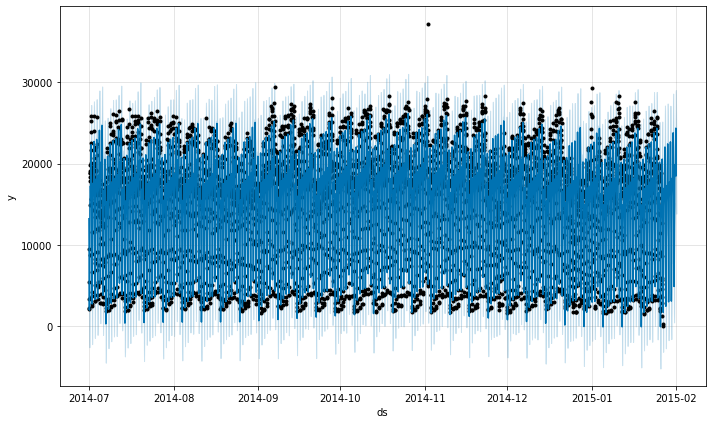

In [22]:
# FB Prophet model comes with a plot and plot_component functions
# dark blue points are the predicted values, black points are actual data points (including outliers) and light blue is the upper and lower confidence interval

fig1 = m.plot(forecast)

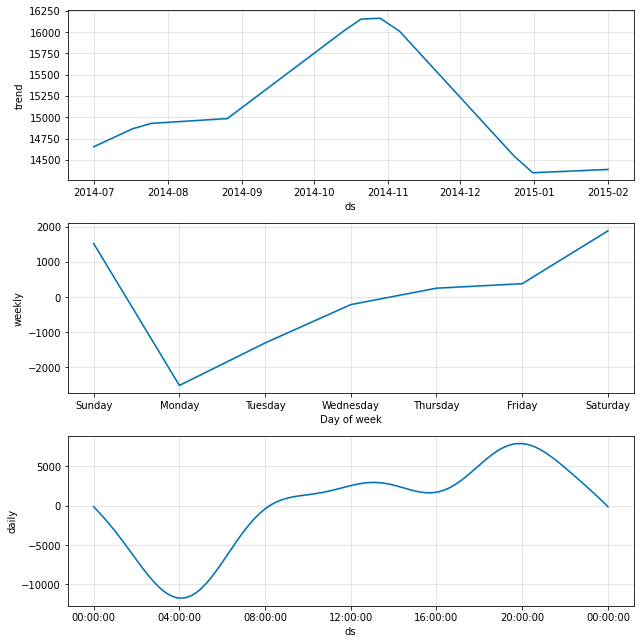

In [23]:
# it will take the time series data and give the trend and seasonality components of that data

comp = m.plot_components(forecast)

Note the last plot above and see that taxi rides reduce after 12 am at night until 4 am in the morning, we will see an anomaly in it later in the code.

In [24]:
# printing the results dataframe with actual and predicted y, lower and upper are the CI limits

results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8608.694515,18054.991704
2014-07-01 01:00:00,5433.0,10220.194393,5655.723014,15222.727793
2014-07-01 02:00:00,3346.5,6656.895387,2190.902914,11411.878081
2014-07-01 03:00:00,2216.5,3435.918478,-1466.169323,8247.274825
2014-07-01 04:00:00,2189.5,2005.330278,-2568.539249,6785.308466


In [25]:
# calculating the residual

results["error"] = results["y"] - results["yhat"]

In [26]:
# uncertainity of our data

results["uncertainity"] = results["yhat_upper"] - results["yhat_lower"]

In [27]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8608.694515,18054.991704,-3742.839092,9446.297189
2014-07-01 01:00:00,5433.0,10220.194393,5655.723014,15222.727793,-4787.194393,9567.004779
2014-07-01 02:00:00,3346.5,6656.895387,2190.902914,11411.878081,-3310.395387,9220.975166
2014-07-01 03:00:00,2216.5,3435.918478,-1466.169323,8247.274825,-1219.418478,9713.444149
2014-07-01 04:00:00,2189.5,2005.330278,-2568.539249,6785.308466,184.169722,9353.847715


In [28]:
results.shape

(5160, 6)

In [29]:
# 1.5 is used to set up our threshold of error, this values needs to come from the domain expertise and can be 2, 3 etc. 
# if we don's use this 1,5 and just compare abs error > uncertainity then we will get a lot of data points as outliers as real world data is not always centered around the mean. If our values are
# centered around the mean then we may want to reduce this 1.5 value or remove it. There is no formula for it. You have choose it based on your analysis and your business problem.

# Below - we see all of the detected anomalies based on our calculation. 
### The first one is on Nov 2, 2014 and that was the marathon day in NY and hence taxis were not much used. This point may be contextual or global. It is outside our data's normal distribution.

### The next 3 values for Jan 1 - 1, 2, 3 o'clock - Jan 1 is new year even and people go to times square and return past 12 o'clock and that's why we don't see the actual downward trend in taxi rides past
### 12 o'clock that we saw in our hourly component plot above.. These points are contextual data points because they do not follow the daily seasonality pattern so even though they look like an inlier
### on the next plot they are actually an outlier. 

### The next 4 observations are for Jan 26th 2015 - NY had a major snow storm on this date and that is why the actual number of rides (actual y) is so low. 

results[results["error"].abs() > 1.5*results["uncertainity"]]

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-11-02 01:00:00,37204.5,14215.495541,9527.818553,18935.155714,22989.004459,9407.337160
2015-01-01 01:00:00,29292.0,11402.685988,6691.782026,16290.416120,17889.314012,9598.634093
2015-01-01 02:00:00,25753.5,7767.243272,2971.576503,12322.715574,17986.256728,9351.139071
2015-01-01 03:00:00,22067.0,4476.113854,-400.779675,9382.019267,17590.886146,9782.798942
2015-01-26 19:00:00,4565.5,19788.034941,14906.528274,24718.303499,-15222.534941,9811.775225
2015-01-26 20:00:00,3630.5,20563.358247,16115.637209,25174.055510,-16932.858247,9058.418301
2015-01-26 21:00:00,2907.0,19664.535017,14845.829346,24406.356120,-16757.535017,9560.526775
2015-01-26 22:00:00,1324.5,17708.853168,12786.634687,22304.833712,-16384.353168,9518.199024
2015-01-26 23:00:00,243.0,15428.310469,10780.421575,19981.551084,-15185.310469,9201.129509


In [30]:
results["anomaly"] = results.apply(lambda x: "Yes" if(np.abs(x["error"]) > 1.5*x["uncertainity"]) else "No", axis=1)

In [31]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8608.694515,18054.991704,-3742.839092,9446.297189,No
2014-07-01 01:00:00,5433.0,10220.194393,5655.723014,15222.727793,-4787.194393,9567.004779,No
2014-07-01 02:00:00,3346.5,6656.895387,2190.902914,11411.878081,-3310.395387,9220.975166,No
2014-07-01 03:00:00,2216.5,3435.918478,-1466.169323,8247.274825,-1219.418478,9713.444149,No
2014-07-01 04:00:00,2189.5,2005.330278,-2568.539249,6785.308466,184.169722,9353.847715,No


In [32]:
fig = px.scatter(results.reset_index(), x="ds", y="y", color="anomaly", title="NYC Taxi Demand")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=1, label="3y", step="year", stepmode="backward"),
                      dict(count=1, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )

)

## Above - 

1. The first red point is for the marathon day and as we can see it is clearly out of the normal distribution (clear outlier).
2. Next 3 red points on Jan 1st look like an inlier but they are not. We can zoom and see that Jan 1 trend for 1 to 3 am does not match with 1 to 3 am trend on other days.
3. Last 4 red points on Jan 26th was the snow storm day in NY and again if we zoom and see it will show that these low points does the match with the trend during those hours as compared to other days.

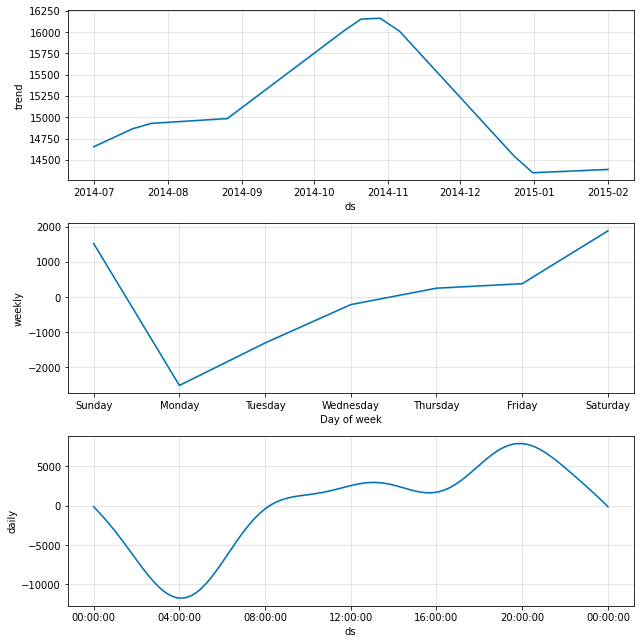

In [33]:
comp = m.plot_components(forecast)

## It is important to look from the context of your business how is your data is getting generated.